In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os 
import pandas as pd 
import random
from skimage import io 
from shutil import copyfile 
import sys 
import time 
 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import load_img,img_to_array

## Read the large dataset with chunks

In [2]:
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv'
Mylist = []
chunksize = 100
for chunk in  pd.read_csv(url, chunksize=chunksize):
    Mylist.append(chunk)
images_boxable = pd.concat(Mylist, axis=0) 

In [3]:
images_boxable.shape

(1743042, 12)

In [4]:
images_boxable.head()

ImageID Subset                                        OriginalURL  \
0  4fa8054781a4c382  train  https://farm3.staticflickr.com/5310/5898076654...   
1  b37f763ae67d0888  train  https://c1.staticflickr.com/1/67/197493648_628...   
2  7e8584b0f487cb9e  train  https://c7.staticflickr.com/8/7056/7143870979_...   
3  86638230febe21c4  train  https://farm5.staticflickr.com/5128/5301868579...   
4  249086e72671397d  train  https://c6.staticflickr.com/4/3930/15342460029...   

                                  OriginalLandingURL  \
0  https://www.flickr.com/photos/michael-beat/589...   
1  https://www.flickr.com/photos/drstarbuck/19749...   
2  https://www.flickr.com/photos/circasassy/71438...   
3  https://www.flickr.com/photos/ajcreencia/53018...   
4  https://www.flickr.com/photos/codnewsroom/1534...   

                                        License  \
0  https://creativecommons.org/licenses/by/2.0/   
1  https://creativecommons.org/licenses/by/2.0/   
2  https://creativecommons.org/licenses/by/2.0/   
3  https://creativecommons.org/licenses/by/2.0/   
4  https://creativecommons.org/licenses/by/2.0/   

                              AuthorProfileURL        Author  \
0  https://www.flickr.com/people/michael-beat/  Michael Beat   
1    https://www.flickr.com/people/drstarbuck/         Karen   
2    https://www.flickr.com/people/circasassy/    CircaSassy   
3    https://www.flickr.com/people/ajcreencia/          Alex   
4   https://www.flickr.com/people/codnewsroom/  COD Newsroom   

                                               Title  OriginalSize  \
0                                   ...die FNF-Kerze       4405052   
1                               Three boys on a hill        494555   
2  A Christmas carol and The cricket on the heart...       2371584   
3                                    Abbey and Kenny        949267   
4  Suburban Law Enforcement Academy 20th Annivers...       6541758   

                OriginalMD5  \
0  KFukvivpCM5QXl5SqKe41g==   
1  9IzEn38GRNsVpATuv7gzEA==   
2  3hQwu0iSzY1VIoXiwp0/Mg==   
3  onB+rCZnGQg5PRX7xOs18Q==   
4  MjpaAVbMAWbCusSaxI1D7w==   

                                    Thumbnail300KURL  Rotation  
0  https://c1.staticflickr.com/6/5310/5898076654_...       0.0  
1  https://c3.staticflickr.com/1/67/197493648_628...       0.0  
2  https://c7.staticflickr.com/8/7056/7143870979_...       0.0  
3  https://c4.staticflickr.com/6/5128/5301868579_...       NaN  
4  https://c1.staticflickr.com/4/3930/15342460029...       0.0

In [5]:
url = "https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv"
datalist = []
chunksize = 100
for chunk in pd.read_csv(url, chunksize=chunksize):
    datalist.append(chunk)
annotations_bbox = pd.concat(datalist,axis=0)

In [6]:
annotations_bbox.shape

(14610229, 13)

In [7]:
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

In [8]:
url = 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv'
classlist = []
chunksize = 100
for chunk in pd.read_csv(url, header=None,chunksize=chunksize): # This dataset doesn't has column names so header = None 
    classlist.append(chunk)
class_descriptions = pd.concat(classlist,axis=0)

In [9]:
class_descriptions.shape

(601, 2)

In [10]:
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

In [21]:
def plot_box(img_id):
    img_url = images_boxable[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
    img = io.imread(img_url) # remember to read image from url we using io here.
    height,width,channel = img.shape
    print(f"Image : {img.shape}")
    bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in bboxs.iterrows():
        xmin = row['XMin']
        xmax = row['XMax']
        ymin = row['YMin']
        ymax = row['YMax']
        xmin = int(xmin*width)
        xmax = int(xmax*width)
        ymin = int(ymin*height)
        ymax = int(ymax*height)
        label_name = row['LabelName']
        try:
            class_series = class_descriptions[class_descriptions[0]==label_name]
            print(class_series)
            class_name = class_series[1].values[0] # it was in dictionary created series
            print(f"Coordinate: {xmin,ymin},{xmax,ymax}")
            cv2.rectangle(img, (xmin,ymin),(xmax,ymax),(255,0,0),5)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0),5)
                                                      # fontscale =3, thickness=5
        except Exception as e:
            print('Exception',e)
            
    plt.figure(figsize=(15,10))
    plt.title('Image with Bounding Box')
    plt.imshow(img)
    plt.axis('off') # This is without axis representation
    plt.show()
        

Image : (960, 1280, 3)
             0             1
217  /m/033rq4  Street light
Coordinate: (436, 61),(809, 919)


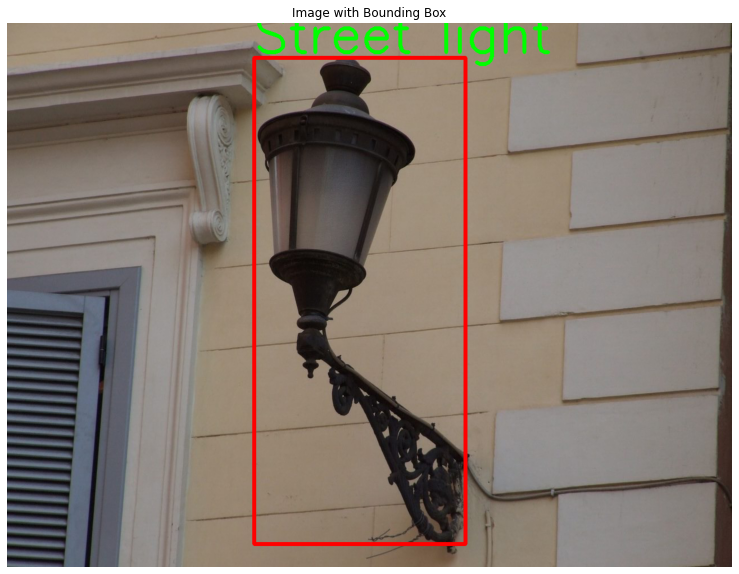

Image : (680, 1024, 3)
            0      1
350  /m/06c54  Rifle
Coordinate: (707, 350),(984, 436)


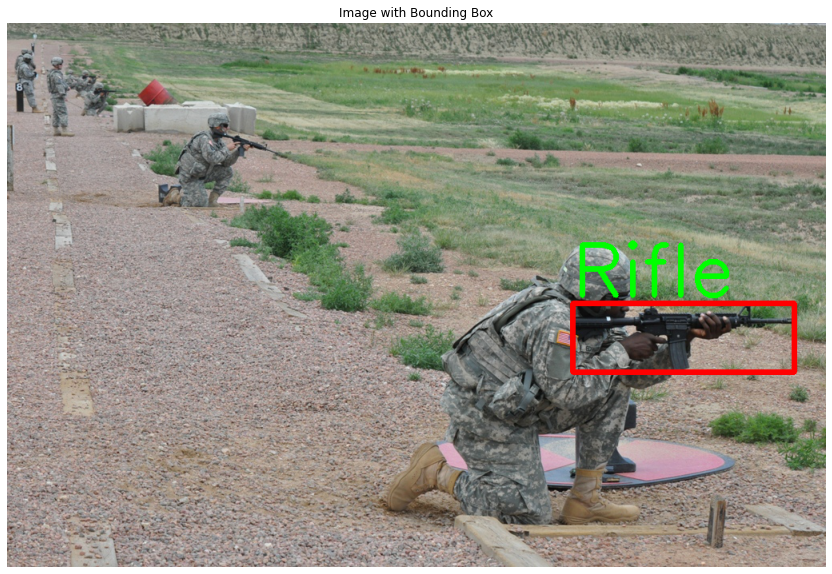

Image : (2616, 3270, 3)
           0     1
42  /m/019jd  Boat
Coordinate: (380, 167),(2840, 2350)


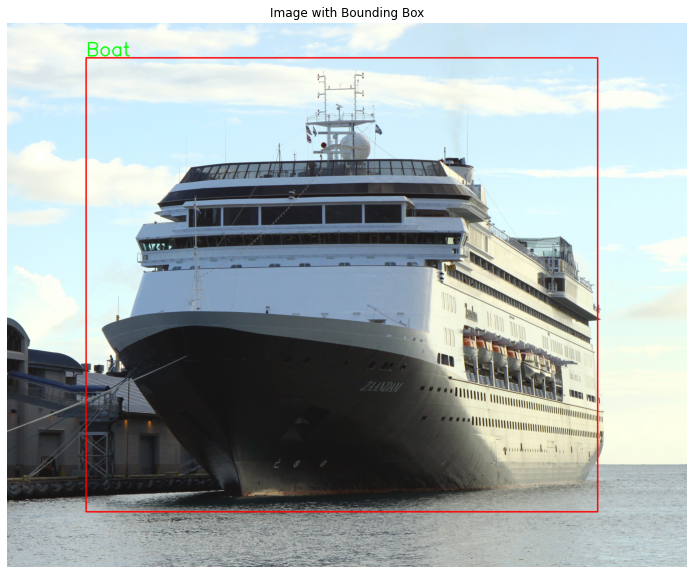

Image : (1696, 2544, 3)
            0          1
358  /m/06msq  Sculpture
Coordinate: (46, 138),(2462, 1696)


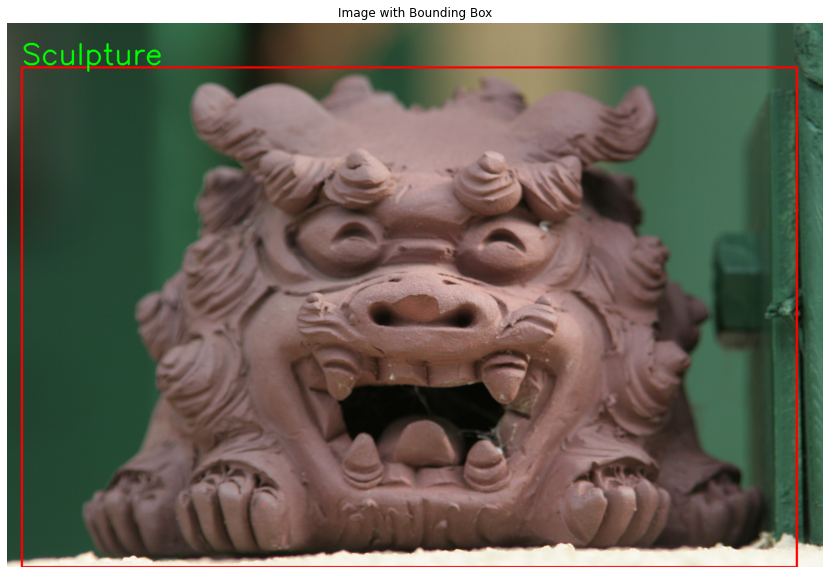

Image : (3240, 4320, 3)
            0     1
390  /m/07j7r  Tree
Coordinate: (2656, 0),(4317, 1711)


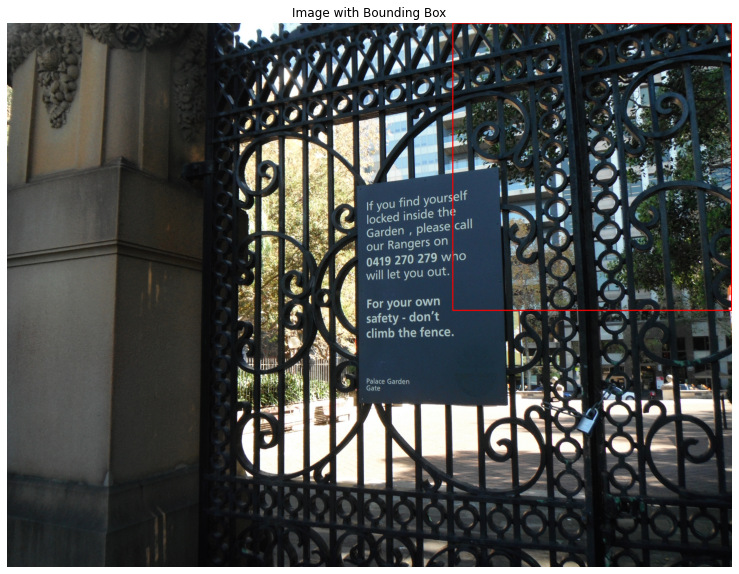

In [22]:
least_objects_img_ids = annotations_bbox['ImageID'].value_counts().tail(100).index.values # here when value_counts used ids are
# in the indexes and its count values are as data so index.values are used 
# the above syntax is to make list of total 50 image ids list and index.values are to return data in the index as arrays

for img_id in random.sample(list(least_objects_img_ids), 5):
    plot_box(img_id) 


In [23]:
class_descriptions[1].count()

601

# ok now we need specific data and extract from specified names.

## So extract label names from specified items

In [24]:
# Find the label_name for 'Bed', 'chair' and 'Table' classes
bed_pd = class_descriptions[class_descriptions[1]=='Bed']
chair_pd = class_descriptions[class_descriptions[1]=='Chair']
table_pd = class_descriptions[class_descriptions[1]=='Table']

In [25]:
bed_pd.value_counts()

0          1  
/m/03ssj5  Bed    1
dtype: int64

In [26]:
label_name_bed = bed_pd[0].values[0]
label_name_chair = chair_pd[0].values[0]
label_name_table = table_pd[0].values[0]

label_name_bed

'/m/03ssj5'

## Now with labels extract data from annotations_bbox for co-ordinates 

In [27]:
bed_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_bed]
chair_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_chair]
table_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_table]

bed_bbox

ImageID     Source  LabelName  Confidence      XMin  \
5953      00041cc3701f7805     xclick  /m/03ssj5           1  0.135112   
5954      00041cc3701f7805     xclick  /m/03ssj5           1  0.179862   
9974      00074503ceae5131     xclick  /m/03ssj5           1  0.000000   
13671     000a54f1bdb96839     xclick  /m/03ssj5           1  0.000000   
17469     000da932ca7e68e4     xclick  /m/03ssj5           1  0.000000   
...                    ...        ...        ...         ...       ...   
14585203  ff7f55b7f6794f63     xclick  /m/03ssj5           1  0.000000   
14595452  ffb716498f082103     xclick  /m/03ssj5           1  0.180000   
14600295  ffce182988b6b746     xclick  /m/03ssj5           1  0.000000   
14602507  ffd718211ba34626  activemil  /m/03ssj5           1  0.006250   
14602925  ffd95054b5fa8ba3     xclick  /m/03ssj5           1  0.000000   

              XMax      YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  \
5953      0.366609  0.420573  0.625000           1            0          0   
5954      0.405336  0.436198  0.856771           0            0          0   
9974      0.999375  0.000000  0.999062           1            1          0   
13671     0.999167  0.028125  0.999375           0            1          0   
17469     0.753125  0.328330  0.993433           1            0          0   
...            ...       ...       ...         ...          ...        ...   
14585203  0.999375  0.000000  0.997500           1            1          0   
14595452  0.998750  0.309568  0.998124           0            0          0   
14600295  0.305625  0.707317  0.999062           0            1          0   
14602507  0.207500  0.373333  0.805000           1            1          0   
14602925  0.928125  0.825000  0.999167           1            1          0   

          IsDepiction  IsInside  
5953                0         0  
5954                0         0  
9974                0         0  
13671               0         0  
17469               0         0  
...               ...       ...  
14585203            0         0  
14595452            0         0  
14600295            0         0  
14602507            0         0  
14602925            0         0  

[3563 rows x 13 columns]

In [28]:
print('There are %d beds in the dataset' %(len(bed_bbox)))
print('There are %d chairs in the dataset' %(len(chair_bbox)))
print('There are %d tables in the dataset' %(len(table_bbox)))

There are 3563 beds in the dataset
There are 132483 chairs in the dataset
There are 85691 tables in the dataset


In [29]:
bed_img_id = bed_bbox['ImageID']
chair_img_id = chair_bbox['ImageID']
table_img_id = table_bbox['ImageID']

# Still there is huge data, so pick 10 items from each items of bed,chair and table randomly.

In [52]:
# Taking only 10 images from each dataset of bed,chair,table id's
n = 10
subbed_img_id = random.sample(list(bed_img_id), n)
subchair_img_id = random.sample(list(chair_img_id), n)
subtable_img_id = random.sample(list(table_img_id), n)

## here with matched and cropped data from annotations sub_data we need again to extract data from images_boxable for url to read or load images.

In [53]:
# creating pd dataset from the wanted items in images_boxable images with isin func(same like == but faster than it)
subbed_pd = images_boxable[images_boxable['ImageID'].isin(subbed_img_id)] 
subchair_pd = images_boxable[images_boxable['ImageID'].isin(subchair_img_id)]
subtable_pd = images_boxable[images_boxable['ImageID'].isin(subtable_img_id)]


In [54]:
subbed_pd.head()

ImageID Subset  \
45320   7a431994861813e0  train   
70045   6deb9cb25ca06867  train   
578691  de29fbe1d2e86e7c  train   
666396  83c3ad95ea7b5a19  train   
961040  a93369564de77ab6  train   

                                              OriginalURL  \
45320   https://farm1.staticflickr.com/3479/3708483560...   
70045   https://farm8.staticflickr.com/3125/3103231956...   
578691  https://c5.staticflickr.com/8/7325/12005670596...   
666396  https://c2.staticflickr.com/9/8205/8202161875_...   
961040  https://farm7.staticflickr.com/3825/9953210395...   

                                       OriginalLandingURL  \
45320   https://www.flickr.com/photos/lancerrevolution...   
70045   https://www.flickr.com/photos/futurestreet/310...   
578691  https://www.flickr.com/photos/wicker-furniture...   
666396  https://www.flickr.com/photos/gigiibrahim/8202...   
961040  https://www.flickr.com/photos/dno1967b/9953210395   

                                             License  \
45320   https://creativecommons.org/licenses/by/2.0/   
70045   https://creativecommons.org/licenses/by/2.0/   
578691  https://creativecommons.org/licenses/by/2.0/   
666396  https://creativecommons.org/licenses/by/2.0/   
961040  https://creativecommons.org/licenses/by/2.0/   

                                       AuthorProfileURL           Author  \
45320   https://www.flickr.com/people/lancerrevolution/          LancerE   
70045       https://www.flickr.com/people/futurestreet/     futurestreet   
578691  https://www.flickr.com/people/wicker-furniture/  Wicker Paradise   
666396       https://www.flickr.com/people/gigiibrahim/    Gigi  Ibrahim   
961040          https://www.flickr.com/people/dno1967b/     Daniel Oines   

                                           Title  OriginalSize  \
45320                            La Quinta Suite        113465   
70045   Series: funny faces with Charlie Lernout       3213337   
578691                               Bouvier Bed         54016   
666396                  Visiting Shifaa Hospital        949455   
961040                                  Untitled       1599806   

                     OriginalMD5  \
45320   +2/wz1fAPSBCuOUddTEChw==   
70045   Y1MoqlRQ+tW1WKXvYBy4QA==   
578691  fs6WBt3c0my8mib7tUUv3w==   
666396  JjcG3IwFruS1Bv7vzAvlaw==   
961040  eCBArwllDdHXxzjX/yuK4g==   

                                         Thumbnail300KURL  Rotation  
45320   https://c4.staticflickr.com/4/3479/3708483560_...       0.0  
70045   https://c3.staticflickr.com/4/3125/3103231956_...       0.0  
578691  https://c4.staticflickr.com/8/7325/12005670596...       0.0  
666396  https://c4.staticflickr.com/9/8205/8202161875_...       0.0  
961040  https://c3.staticflickr.com/4/3825/9953210395_...       0.0

In [55]:
# picking url with image id setting as index and  also in dictionary format
subbed_dict = subbed_pd[["ImageID","OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subchair_dict = subchair_pd[["ImageID","OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subtable_dict = subtable_pd[["ImageID","OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()


In [56]:
mappings = [subbed_dict,subchair_dict,subtable_dict]

In [57]:
subbed_dict

{'7a431994861813e0': 'https://farm1.staticflickr.com/3479/3708483560_349591b6f8_o.jpg',
 '6deb9cb25ca06867': 'https://farm8.staticflickr.com/3125/3103231956_2c689fa265_o.jpg',
 'de29fbe1d2e86e7c': 'https://c5.staticflickr.com/8/7325/12005670596_4dd5175f6d_o.jpg',
 '83c3ad95ea7b5a19': 'https://c2.staticflickr.com/9/8205/8202161875_25210339cc_o.jpg',
 'a93369564de77ab6': 'https://farm7.staticflickr.com/3825/9953210395_1c34f66462_o.jpg',
 '931f3ef71737c36e': 'https://c7.staticflickr.com/6/5003/5331589745_9c89cf7869_o.jpg',
 '0363bd1c5e890346': 'https://farm7.staticflickr.com/2582/3752449123_0948830a09_o.jpg',
 'c9a7cd591c8eeb1b': 'https://c4.staticflickr.com/2/1160/1465504030_fb0d3aa63e_o.jpg',
 'da5ddd1f6ad15db9': 'https://c2.staticflickr.com/2/1396/1269842540_1d73abbb51_o.jpg',
 '1b45110be25b4901': 'https://farm2.staticflickr.com/3625/3490028464_523fede172_o.jpg'}

In [58]:
len(mappings)

3

In [59]:
len(mappings[0])

10

In [60]:
classes = ['Bed','Chair','Table']

In [61]:
# download images in folders(Bed, chair, Table folder with 10 images each)

for idx,obj_type in enumerate(classes):
    n_issues = 0
    # create the dictionary or folder 
    if not os.path.exists(obj_type):
        os.mkdir(obj_type)
        print(obj_type)
        print(idx)
    for img_id,url in mappings[idx].items():
        try:
            img = io.imread(url)  # first read the data,then combine the path
            savedpath = os.path.join(obj_type,img_id +'.jpg') # now obj_type is a created folder of one of classes
            io.imsave(savedpath,img) # the then save over in combined path which is created dictionary
        except Exception as e:
            n_issues += 1
        print(f"Images Issues:{n_issues}") 
            

Images Issues:0
Images Issues:0
Images Issues:0
Images Issues:0
Images Issues:1
Images Issues:1
Images Issues:2
Images Issues:2
Images Issues:2
Images Issues:2
Images Issues:0
Images Issues:0
Images Issues:0
Images Issues:1
Images Issues:2
Images Issues:2
Images Issues:3
Images Issues:4
Images Issues:4
Images Issues:5
Images Issues:0
Images Issues:0
Images Issues:1
Images Issues:1
Images Issues:1
Images Issues:1
Images Issues:1
Images Issues:1
Images Issues:1
Images Issues:1


# Dataset format for Faster-RCNN code

## (fname_path,xmin,xmax,ymin,ymax,class_name)

In [50]:
limit = int(n*0.8) # to convert decimal to int 

In [51]:
limit

8

In [62]:
# save images to train and test directory, so create 2 folders
train_path = 'train'
test_path = 'test'

In [68]:
# Load images in to train and test folders
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8) # 80% data for training and 20% for testing
    
    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:10] # if more images present,better to mention stop conviction also coz 10 imgs only needed
    
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path,train_imgs[j])
        copyfile(original_path,new_path) # here instead of reading & saving imgs in a path, we are combining the paths of 
                                       # required imgs and copying the files in original path to new path)
        
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path,test_imgs[j])
        copyfile(original_path,new_path)
        
        

In [69]:
train_img_count = os.listdir(r"D:\ANACONDA\Project-8\train") 
print("Number of images in train found: ", len(train_img_count))

Number of images in train found:  33


In [70]:
test_img_count = os.listdir(r"D:\ANACONDA\Project-8\test")
print("Number of images in test found:",len(test_img_count))

Number of images in test found: 13


In [83]:
label_names = [label_name_bed,label_name_chair,label_name_table]

train_df = pd.DataFrame(columns=['FileName','XMin','XMax','YMin','YMax','ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('parse train_imgs' +  str(i) + '; Number of boxes:' + str(len(train_df)) + '\r') # it is to print directly 
    sys.stdout.flush()                  # at console and carriage return is to get cursor at first and replace string 
    print(train_df)
    img_name = train_imgs[i]           # image name is nothing but image id 
    img_id = img_name[0:16]             # because we added jpg extension to the image id's last name. 
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id] # to assign the no. of images with same id in annotations box
    for index,row in tmp_df.iterrows(): # tmp_df is temporary df again to append with suited labels further in train_df
        labelName = row['LabelName']                  # assigning bunch of labels for existing same and  multiple image ids
        print('\n',labelName) 
        for i in range(len(label_names)): # again in those bunch of labels taking loop to match one of it 
            if labelName == label_names[i]:# if labels of bed,chair,table any of it matching with labels cropped from annotation
                train_df = train_df.append({'FileName': img_name,                                                   # box
                                           'XMin':row['XMin'],
                                           'XMax':row['XMax'],
                                           'YMin':row['YMin'],
                                           'YMax':row['YMax'],
                                           'ClassName': classes[i]},
                                          ignore_index = True) 
 # ignore index coz already columns formed in train_df. index is like cols in iter.row() function                


Empty DataFrames0; Number of boxes:0
Columns: [FileName, XMin, XMax, YMin, YMax, ClassName]
Index: []

 /m/03ssj5
               FileName  XMin      XMax  YMin      YMax ClassName
0  026319ec416e1d12.jpg   0.0  0.998333   0.0  0.997778       Bed

 /m/01g317

 /m/01g317

 /m/01y9k5

 /m/04bcr3
               FileName  XMin      XMax      YMin      YMax ClassName
0  026319ec416e1d12.jpg   0.0  0.998333  0.000000  0.997778       Bed
1  117e0616bdbe2405.jpg   0.0  0.966250  0.731463  0.997996     Table

 /m/04yx4

 /m/09j2d

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/01mzpv

 /m/0

- Note: Number of boxes: are for each image in train_imgaes matching with no. of multiple images bounding box in annotations bbox with same id and labels
 -  Here not just matching with same image id and taking bbox coordinates isn't enough coz there are muliple images with same
     id's and also multiple labels for same image id.So also match with label name of bed,chair,table with cropped annotations bbox.

In [84]:
train_df.head()

FileName   XMin      XMax      YMin      YMax ClassName
0  026319ec416e1d12.jpg  0.000  0.998333  0.000000  0.997778       Bed
1  117e0616bdbe2405.jpg  0.000  0.966250  0.731463  0.997996     Table
2  17af90ae78244f01.jpg  0.010  0.068750  0.484053  0.508443     Chair
3  17af90ae78244f01.jpg  0.015  0.078125  0.466229  0.522514     Chair
4  17af90ae78244f01.jpg  0.015  0.081875  0.499062  0.560976     Chair

In [85]:
train_df.shape

(240, 6)

In [86]:

test_df = pd.DataFrame(columns=['FileName','XMin','XMax','YMin','YMax','ClassName'])

# Find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('parse test_imgs' +  str(i) + '; Number of boxes:' + str(len(test_df)) + '\r') 
    sys.stdout.flush()                
    img_name = test_imgs[i]          
    img_id = img_name[0:16]             
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id] 
    for index,row in tmp_df.iterrows():
        labelName = row['LabelName']              
        for i in range(len(label_names)): 
            if labelName == label_names[i]:
                test_df = test_df.append({'FileName': img_name,                                                  
                                           'XMin':row['XMin'],
                                           'XMax':row['XMax'],
                                           'YMin':row['YMin'],
                                           'YMax':row['YMax'],
                                           'ClassName': classes[i]},
                                          ignore_index = True) 
     


In [90]:
test_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  180eaae399121a8c.jpg  0.218750  0.338125  0.510000  0.675833     Chair
1  180eaae399121a8c.jpg  0.757500  0.834375  0.594167  0.757500     Chair
2  180eaae399121a8c.jpg  0.795000  0.856875  0.513333  0.653333     Chair
3  180eaae399121a8c.jpg  0.311875  0.447500  0.227500  0.406667       Bed
4  180eaae399121a8c.jpg  0.636250  0.817500  0.230833  0.390000       Bed

['026319ec416e1d12' '117e0616bdbe2405' '17af90ae78244f01']
Image : (450, 600, 3)
             0    1
257  /m/03ssj5  Bed
Coordinate: (0, 0),(598, 449)


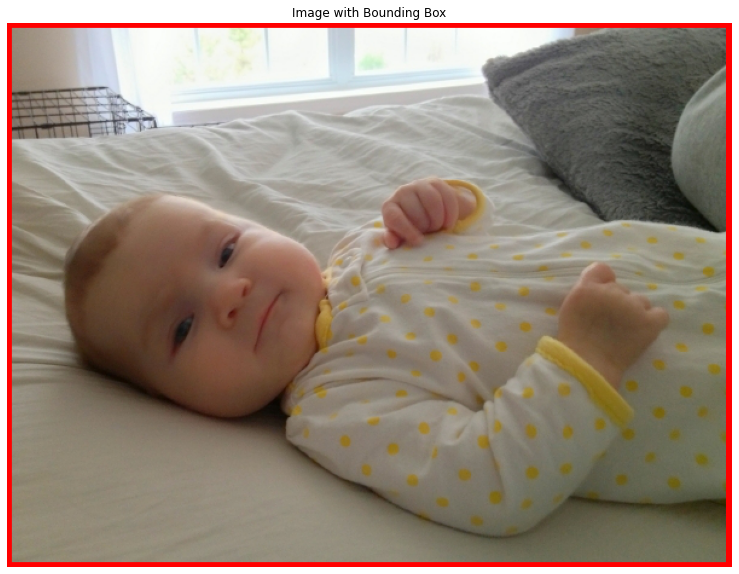

Image : (499, 800, 3)
            0       1
68  /m/01g317  Person
Coordinate: (0, 205),(217, 408)
            0       1
68  /m/01g317  Person
Coordinate: (514, 116),(799, 498)
             0     1
120  /m/01y9k5  Desk
Coordinate: (5, 374),(764, 498)
             0      1
280  /m/04bcr3  Table
Coordinate: (0, 365),(773, 498)


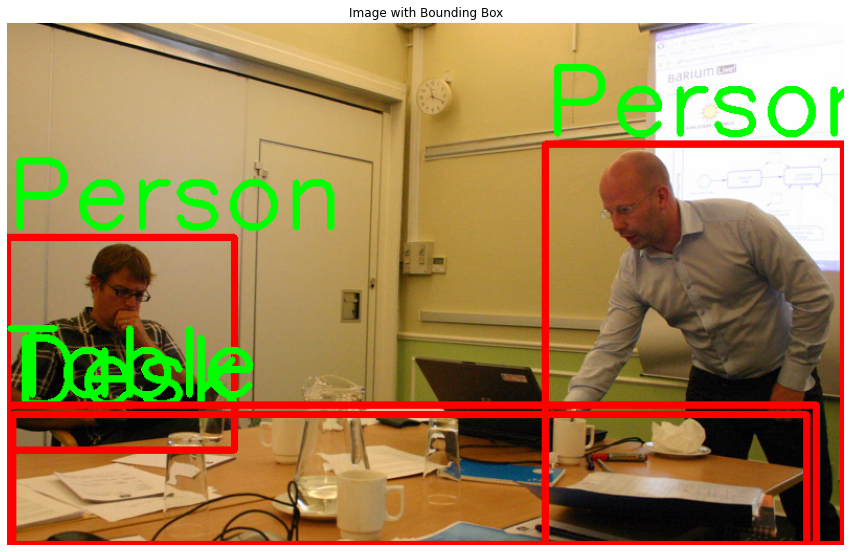

Image : (2592, 3888, 3)
            0    1
307  /m/04yx4  Man
Coordinate: (1023, 1101),(1839, 2285)
            0         1
432  /m/09j2d  Clothing
Coordinate: (1093, 1137),(1676, 2173)
            0      1
96  /m/01mzpv  Chair
Coordinate: (38, 1254),(267, 1317)
            0      1
96  /m/01mzpv  Chair
Coordinate: (58, 1208),(303, 1354)
            0      1
96  /m/01mzpv  Chair
Coordinate: (58, 1293),(318, 1454)
            0      1
96  /m/01mzpv  Chair
Coordinate: (58, 1548),(575, 1952)
            0      1
96  /m/01mzpv  Chair
Coordinate: (68, 1843),(546, 2015)
            0      1
96  /m/01mzpv  Chair
Coordinate: (72, 1483),(636, 1952)
            0      1
96  /m/01mzpv  Chair
Coordinate: (77, 1398),(422, 1838)
            0      1
96  /m/01mzpv  Chair
Coordinate: (267, 1313),(597, 1422)
            0      1
96  /m/01mzpv  Chair
Coordinate: (337, 1354),(697, 1811)
            0      1
96  /m/01mzpv  Chair
Coordinate: (347, 1203),(607, 1330)
            0      1
96  /m/01mzpv  Chair

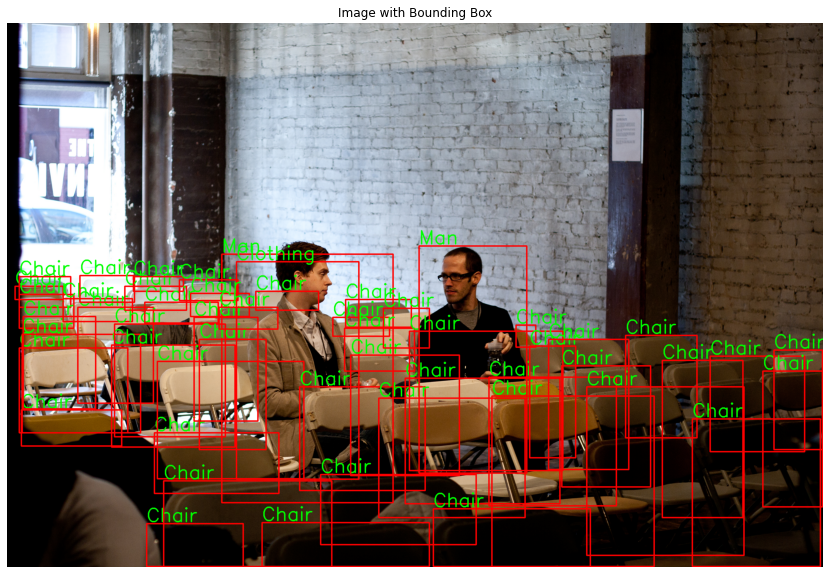

In [97]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique() # plotting the bounding box
print(train_img_ids)
for img_id in train_img_ids:
    plot_box(img_id)


In [88]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [95]:
# we made train dataset format in required form but to read imgs in train again concaticate train imgs

#  write train.csv to annotation.txt
train_df = pd.read_csv('train.csv')

# for training 
with open('annotation.txt','w+') as f:
    for idx, row in train_df.iterrows():  
        img = cv2.imread('train/' + row['FileName']) # we reading each image from train with adding its identity of image id from train_df
        print(img)
        height, width = img.shape[:2] # coz to leave channels
        print(f"image shape: {img.shape}") 
        x1 = int(row['XMin']*width)
        x2 = int(row['XMax']*width)
        y1 = int(row['YMin']*height)
        y2 = int(row['YMax']*height) 
        
        train_file_path = train_path
        fileName = os.path.join(train_file_path,row['FileName'])
        className = row['ClassName']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n') 

[[[117 139 151]
  [116 138 150]
  [116 138 150]
  ...
  [117 125 118]
  [113 121 114]
  [112 120 113]]

 [[117 139 151]
  [116 138 150]
  [116 138 150]
  ...
  [ 87  95  88]
  [ 90  98  91]
  [ 96 104  97]]

 [[116 138 150]
  [116 138 150]
  [116 138 150]
  ...
  [ 59  66  61]
  [ 65  72  67]
  [ 76  83  78]]

 ...

 [[108 129 137]
  [108 129 137]
  [108 130 136]
  ...
  [ 81 110 107]
  [ 82 108 108]
  [ 79 108 105]]

 [[111 131 142]
  [110 130 141]
  [110 131 139]
  ...
  [ 83 115 110]
  [ 83 112 109]
  [ 78 110 105]]

 [[111 130 143]
  [111 131 142]
  [110 130 141]
  ...
  [ 83 115 110]
  [ 81 113 108]
  [ 78 110 105]]]
image shape: (450, 600, 3)
[[[ 99 145 176]
  [ 99 145 176]
  [ 99 145 176]
  ...
  [253 253 253]
  [253 253 253]
  [253 253 253]]

 [[ 99 145 176]
  [ 99 145 176]
  [ 99 145 176]
  ...
  [253 253 253]
  [253 253 253]
  [253 253 253]]

 [[100 146 177]
  [100 146 177]
  [ 99 145 176]
  ...
  [253 253 253]
  [253 253 253]
  [253 253 253]]

 ...

 [[ 40 113 173]
  [ 38 11

In [98]:
test_df = pd.read_csv('test.csv')

# for training 
with open('test_annotation.txt','w+') as f: 
    for idx, row in test_df.iterrows():
        sys.stdout.write(str(idx) + '\r')
        sys.stdout.flush()
        img = cv2.imread('test/' + row['FileName']) 
        print(img)
        height, width = img.shape[:2] 
        print(f"image shape: {img.shape}") 
        x1 = int(row['XMin']*width)
        x2 = int(row['XMax']*width)
        y1 = int(row['YMin']*height)
        y2 = int(row['YMax']*height) 
        
        test_file_path = test_path
        fileName = os.path.join(test_file_path,row['FileName'])
        className = row['ClassName']
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className +  '\n') 



[[[6 5 7]
  [5 4 6]
  [5 4 6]
  ...
  [3 2 4]
  [3 2 4]
  [3 2 4]]

 [[5 4 6]
  [5 4 6]
  [4 3 5]
  ...
  [3 2 4]
  [3 2 4]
  [3 2 4]]

 [[4 3 5]
  [4 3 5]
  [3 2 4]
  ...
  [3 2 4]
  [3 2 4]
  [3 2 4]]

 ...

 [[4 3 5]
  [4 3 5]
  [4 3 5]
  ...
  [2 2 2]
  [2 2 2]
  [2 2 2]]

 [[4 3 5]
  [4 3 5]
  [4 3 5]
  ...
  [2 2 2]
  [2 2 2]
  [2 2 2]]

 [[4 3 5]
  [4 3 5]
  [4 3 5]
  ...
  [2 2 2]
  [2 2 2]
  [2 2 2]]]
image shape: (3000, 4000, 3)
[[[6 5 7]
  [5 4 6]
  [5 4 6]
  ...
  [3 2 4]
  [3 2 4]
  [3 2 4]]

 [[5 4 6]
  [5 4 6]
  [4 3 5]
  ...
  [3 2 4]
  [3 2 4]
  [3 2 4]]

 [[4 3 5]
  [4 3 5]
  [3 2 4]
  ...
  [3 2 4]
  [3 2 4]
  [3 2 4]]

 ...

 [[4 3 5]
  [4 3 5]
  [4 3 5]
  ...
  [2 2 2]
  [2 2 2]
  [2 2 2]]

 [[4 3 5]
  [4 3 5]
  [4 3 5]
  ...
  [2 2 2]
  [2 2 2]
  [2 2 2]]

 [[4 3 5]
  [4 3 5]
  [4 3 5]
  ...
  [2 2 2]
  [2 2 2]
  [2 2 2]]]
image shape: (3000, 4000, 3)
[[[6 5 7]
  [5 4 6]
  [5 4 6]
  ...
  [3 2 4]
  [3 2 4]
  [3 2 4]]

 [[5 4 6]
  [5 4 6]
  [4 3 5]
  ...
  [3 2 4]
